# Final Evaluation 

In this notebook the final resut is going to be evaluated. The data is first loaded into the Notebokk and then loaded into the current database.
After that the pipeline in the scope of this thesis is applied and the results collected for final evaluation

#### Loading the data

In [16]:
import sys
import os
import pandas
import numpy
import re
import time
import csv
import os
import numpy as np

from Main.combined_pipeline import combined_pipeline
from Utilities.llm import get_embedding
path="Data/itunes_amazon_raw_data/labeled_data.csv"

#Read the file
data=pandas.read_csv(path, skiprows=5, encoding='unicode_escape')
data=data[data["label"]==1]
print(data.shape)


(132, 17)


In [10]:
data.head()

,Unnamed: 0,_id,ltable.Sno,rtable.Sno,ltable.Album_Name,ltable.Artist_Name,ltable.CopyRight,ltable.Released,ltable.Song_Name,ltable.Time,rtable.Album_Name,rtable.Artist_Name,rtable.CopyRight,rtable.Released,rtable.Song_Name,rtable.Time,label
0,916,916,111,53124,vhs,x ambassadors,2015 kidinakorner/interscope records,30-Jun-15,vhs outro (interlude),1:25,vhs [explicit],x ambassadors,(c) 2015 kidinakorner/interscope records,"June 30, 2015",vhs outro (interlude) [explicit],1:25,1
1,1053,1053,148,50767,title (deluxe),meghan trainor,"2014, 2015 epic records, a division of sony m...",9-Jan-15,credit,2:51,title (deluxe),meghan trainor,"2011 what a music ltd, licence exclusive parl...","January 9, 2015",credit,2:51,1
2,1290,1290,206,41214,slow down (remixes),selena gomez,"2013 hollywood records, inc.",20-Aug-13,slow down (smash mode remix),5:21,slow down remixes,selena gomez,"(c) 2013 hollywood records, inc.","August 20, 2013",slow down (smash mode remix),5:21,1
5,1710,1710,250,53124,vhs,x ambassadors,2015 kidinakorner/interscope records,30-Jun-15,vhs outro (interlude),1:25,vhs [explicit],x ambassadors,(c) 2015 kidinakorner/interscope records,"June 30, 2015",vhs outro (interlude) [explicit],1:25,1
7,1766,1766,252,53004,vhs,x ambassadors,2015 kidinakorner/interscope records,30-Jun-15,vhs outro (interlude),1:25,vhs,x ambassadors,(c) 2015 kidinakorner/interscope records,"June 30, 2015",vhs outro (interlude),1:26,1


In [11]:
class_vector=data['label']
left_table=data.iloc[:,4:10]
right_table=data.iloc[:,10:16]

In [12]:
right_table=right_table.apply(lambda row: '\n'.join(row.astype(str)), axis=1)
print(f"Length of unique values of right_table is {len(right_table.unique())}")

left_table=left_table.apply(lambda row: '\n'.join(row.astype(str)), axis=1)
print(f"Length of unique values of left_table is {len(left_table.unique())}")


Length of unique values of right_table is 119
Length of unique values of left_table is 110


In [14]:
left_unique=left_table.unique()
right_unique=right_table.unique()

In [ ]:
left_unique_embeddings = [get_embedding(item) for item in left_table.unique()]
right_unique_embeddings = [get_embedding(item) for item in right_table.unique()]

In [21]:
left_unique_embeddings_reshape=[np.array(i).reshape(1,-1) for i in left_unique_embeddings]
right_unique_embeddings_reshape=[np.array(i).reshape(1,-1) for i in right_unique_embeddings]  

In [27]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


cosine_sim_matrix = np.zeros((len(left_unique_embeddings), len(right_unique_embeddings)))

for i in range(len(left_unique_embeddings)):
    for j in range(len(right_unique_embeddings)):
        cosine_sim_matrix[i][j] = cosine_similarity(left_unique_embeddings_reshape[i], right_unique_embeddings_reshape[j])[0][0]


/tmp/ipykernel_599613/2448032657.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Group", y="Cosine Similarity", data=cosine_sim_df, inner="quart", scale="width", palette="Set2")
/tmp/ipykernel_599613/2448032657.py:21: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x="Group", y="Cosine Similarity", data=cosine_sim_df, inner="quart", scale="width", palette="Set2")


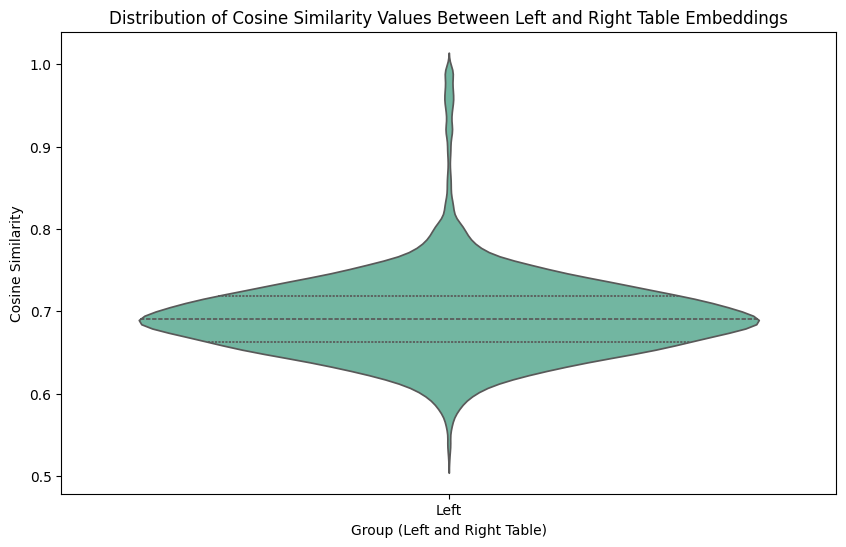

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Flatten the cosine similarity matrix and create a DataFrame for plotting
cosine_sim_values = []

for i in range(len(left_unique_embeddings)):
    for j in range(len(right_unique_embeddings)):
        cosine_sim_values.append(cosine_similarity(left_unique_embeddings_reshape[i], right_unique_embeddings_reshape[j])[0][0])

# Convert the list of cosine similarity values into a DataFrame
cosine_sim_df = pd.DataFrame(cosine_sim_values, columns=["Cosine Similarity"])

# Create a 'Group' column to distinguish between the two sets (left and right)
cosine_sim_df['Group'] = ['Left' for _ in range(len(left_unique_embeddings) * len(right_unique_embeddings))]

# Plotting the violin plot with Seaborn
plt.figure(figsize=(10, 6))
sns.violinplot(x="Group", y="Cosine Similarity", data=cosine_sim_df, inner="quart", scale="width", palette="Set2")

# Adding title and labels
plt.title('Distribution of Cosine Similarity Values Between Left and Right Table Embeddings')
plt.xlabel('Group (Left and Right Table)')
plt.ylabel('Cosine Similarity')

# Show plot
plt.show()

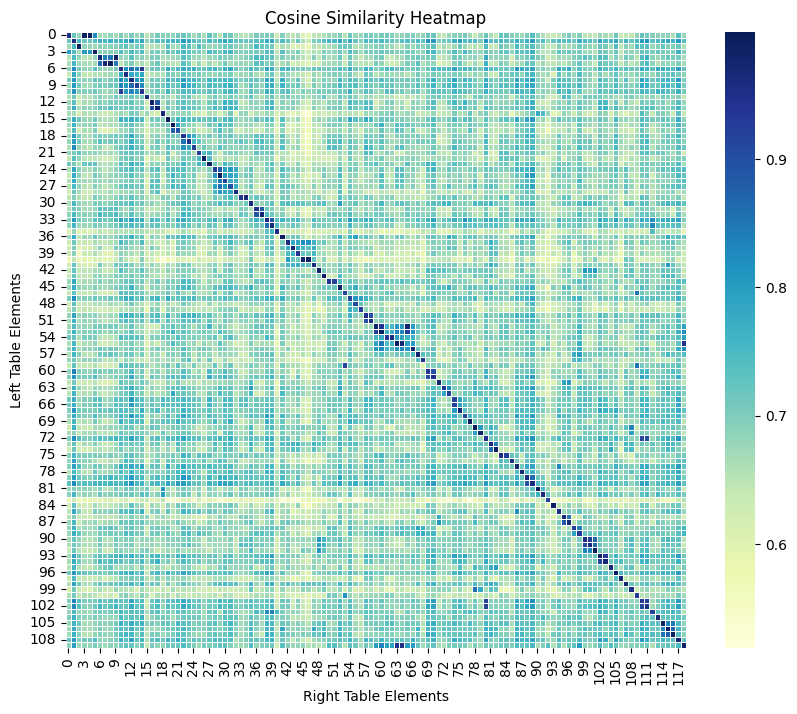

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap of the cosine similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_matrix, annot=False, cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title('Cosine Similarity Heatmap')
plt.xlabel('Right Table Elements')
plt.ylabel('Left Table Elements')
plt.show()


/tmp/ipykernel_599613/1812527762.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Cosine Similarity', data=cosine_sim_df, palette="Set2")


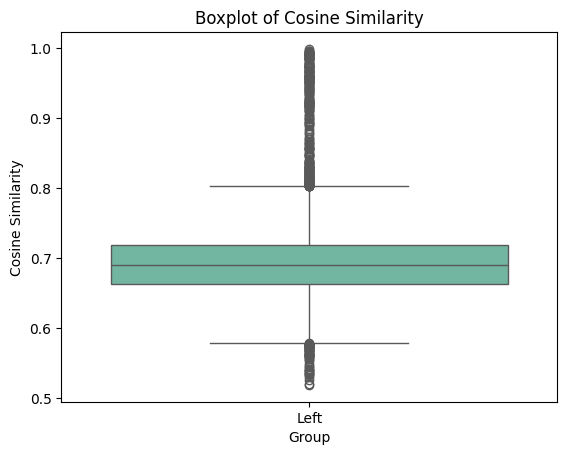

In [33]:
sns.boxplot(x='Group', y='Cosine Similarity', data=cosine_sim_df, palette="Set2")
plt.title('Boxplot of Cosine Similarity')
plt.show()


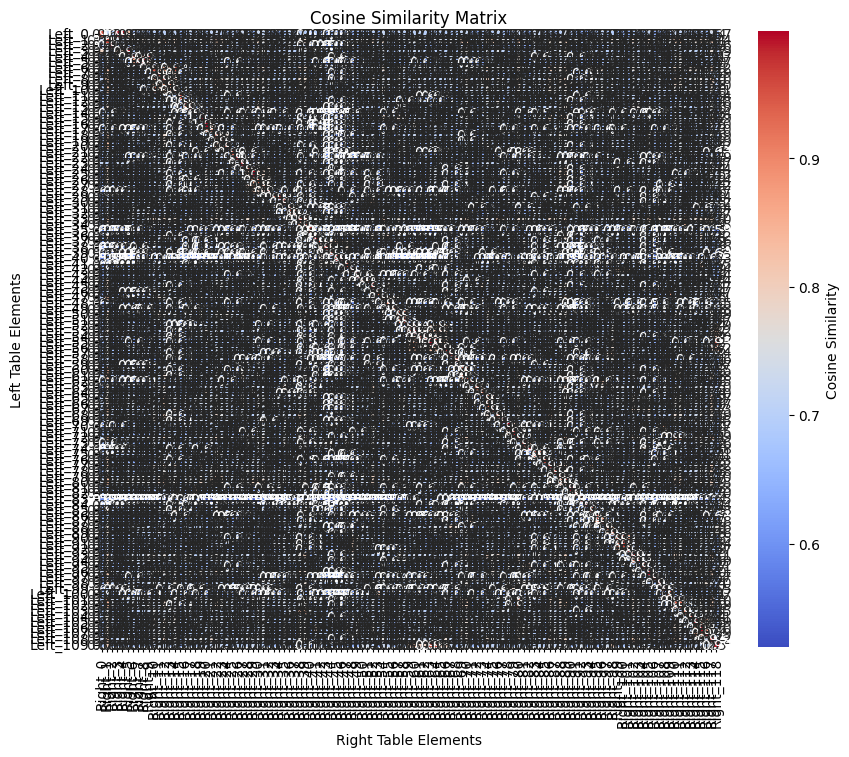

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming cosine_sim_matrix is already computed as described
# Convert the cosine_sim_matrix into a DataFrame for easy plotting with Seaborn
import pandas as pd

# Creating a DataFrame for better visualization
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, columns=[f"Right_{i}" for i in range(len(right_unique_embeddings))],
                             index=[f"Left_{i}" for i in range(len(left_unique_embeddings))])

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_df, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Cosine Similarity'},
            xticklabels=cosine_sim_df.columns, yticklabels=cosine_sim_df.index)
plt.title('Cosine Similarity Matrix')
plt.xlabel('Right Table Elements')
plt.ylabel('Left Table Elements')
plt.show()

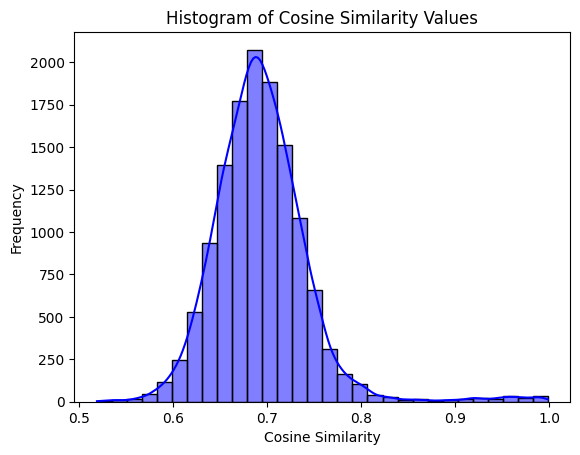

In [34]:
sns.histplot(cosine_sim_values, kde=True, color="blue", bins=30)
plt.title('Histogram of Cosine Similarity Values')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()


/tmp/ipykernel_599613/2096556831.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cosine_sim_values, shade=True, color="green")


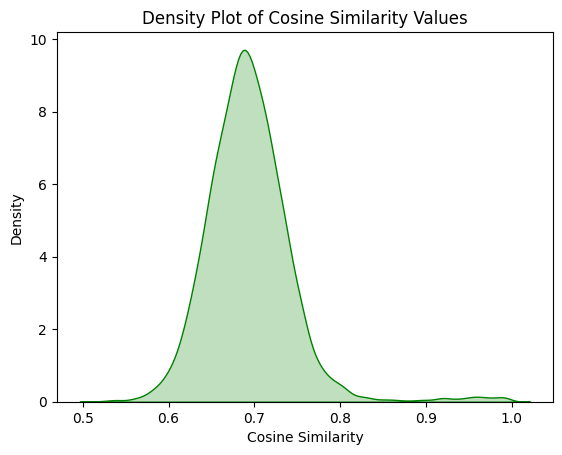

In [35]:
sns.kdeplot(cosine_sim_values, shade=True, color="green")
plt.title('Density Plot of Cosine Similarity Values')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.show()

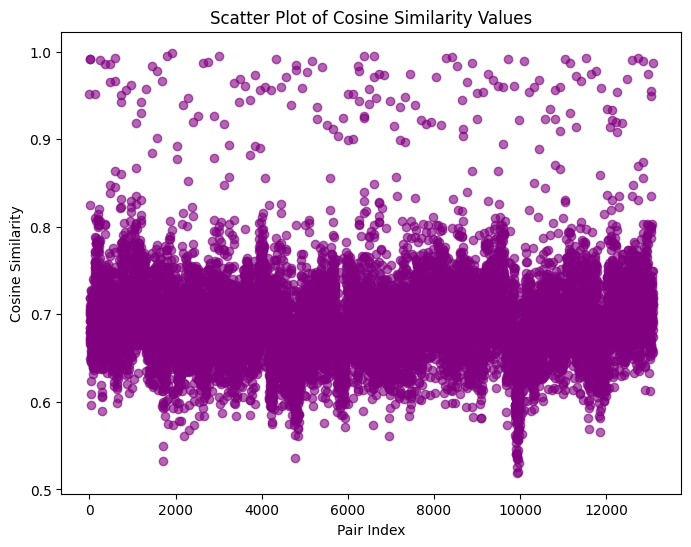

In [36]:
plt.figure(figsize=(8,6))
plt.scatter(range(len(cosine_sim_values)), cosine_sim_values, alpha=0.6, color='purple')
plt.title('Scatter Plot of Cosine Similarity Values')
plt.xlabel('Pair Index')
plt.ylabel('Cosine Similarity')
plt.show()

In [ ]:
# Assuming left_unique_embeddings and right_unique_embeddings are 3D arrays of shape (110, 1, 768)
# Reshape them to 2D (110, 768)
left_unique_embeddings_reshaped = np.squeeze(left_unique_embeddings)  # Remove the second dimension
right_unique_embeddings_reshaped = np.squeeze(right_unique_embeddings)

# Check that the shape is now (110, 768)
print(left_unique_embeddings_reshaped.shape)  # Should print (110, 768)
print(right_unique_embeddings_reshaped.shape)  # Should print (110, 768)

# Create DataFrames
left_df = pd.DataFrame(left_unique_embeddings_reshaped)
right_df = pd.DataFrame(right_unique_embeddings_reshaped)

# Concatenate the DataFrames along the columns
concatenated_df = pd.concat([left_df, right_df], axis=1)

# Calculate the correlation matrix
correlation_matrix = concatenated_df.corr()

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Heatmap of Left and Right Embeddings')
plt.show()

(110, 768)
(119, 768)


IndexError: index 1 is out of bounds for axis 1 with size 1

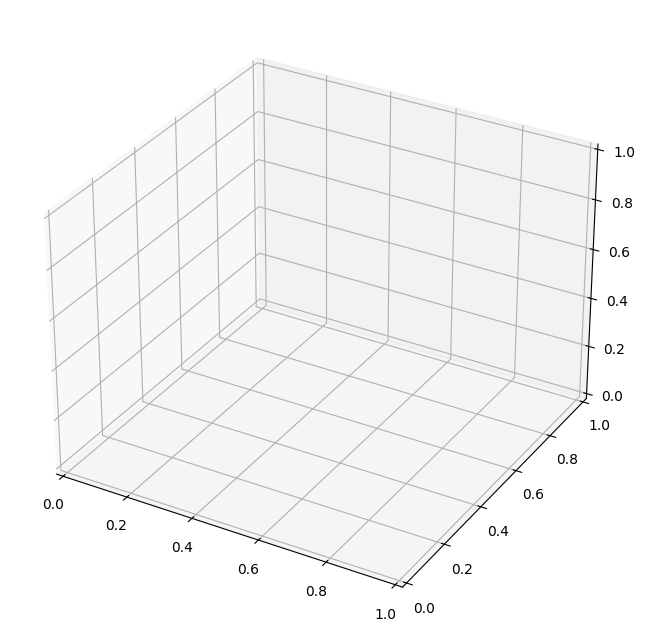

In [39]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(left_unique_embeddings[:, 0], left_unique_embeddings[:, 1], left_unique_embeddings[:, 2], color='blue', label='Left Table')
ax.scatter(right_unique_embeddings[:, 0], right_unique_embeddings[:, 1], right_unique_embeddings[:, 2], color='red', label='Right Table')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('3D Plot of Left and Right Embeddings')
plt.legend()
plt.show()